# Chest X-Ray Medical Diagnosis with Deep Learning

<img src="xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">

__Welcome to the first Assignment 3!__

In this assignment! You will explore medical image diagnosis by building a state-of-the-art chest X-ray classifier using Pytorch.

The assignment will walk through some of the steps of building and evaluating this deep learning classifier model. In particular, you will:
- Pre-process and prepare a real-world X-ray dataset
- Use transfer learning to retrain a DenseNet model for X-ray image classification
- Learn a technique to handle class imbalance
- Measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve
- Visualize model activity using GradCAMs

In completing this assignment you will learn about the following topics:

- Data preparation
  - Visualizing data
  - Preventing data leakage
- Model Development
  - Addressing class imbalance
  - Leveraging pre-trained models using transfer learning
- Evaluation
  - AUC and ROC curves

## Outline
Use these links to jump to specific sections of this assignment!

- [1. Import Packages and Function](#1)
- [2. Load the Datasets](#2)
    - [2.1 Preventing Data Leakage](#2-1)
        - [Exercise 1 - Checking Data Leakage](#Ex-1)
    - [2.2 Preparing Images](#2-2)
- [3. Model Development](#3)
    - [3.1 Addressing Class Imbalance](#3-1)
        - [Exercise 2 - Computing Class Frequencies](#Ex-2)
        - [Exercise 3 - Weighted Loss](#Ex-3)
    - [3.3 DenseNet121](#3-3)
- [4. Training [optional]](#4)
    - [4.1 Training on the Larger Dataset](#4-1)
- [5. Prediction and Evaluation](#5)
    - [5.1 ROC Curve and AUROC](#5-1)
    - [5.2 Visualizing Learning with GradCAM](#5-2)

<a name='1'></a>
## 1. Import Packages and Functions¶

We'll make use of the following packages:
- `numpy` and `pandas` is what we'll use to manipulate our data
- `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization

We will also use several modules from the `Pytorch` framework for building deep learning models.

Run the next cell to import all the necessary packages.

In [74]:
!pip install pytorch_lightning

In [75]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.optim import Adam
from google.cloud import bigquery
import pytorch_lightning as pl
from PIL import Image


In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data download

I used the following bash script to download the data, first at the root directory then the sampled patients

```bash
#!/bin/bash

root_url="https://physionet.org/files/mimic-cxr-jpg/2.0.0/"

# the pacient subset
sub_path="files/p10/"

sub_url="${root_url}${sub_path}"

# Maximum number of directories to download
max_folders=100

# User and password
user=
password=

# Download all files in root directory
wget -N -c -r -q -np --show-progress --user=$user --password=$password --quota=1G --no-directories $root_url


echo "Downloaded all files in root directory"

# list of subdirectories in the p10 folder (excluding ./ and ../, as they are recursive)
subdirs=$(wget -q --user=$user --password=$password -O - $sub_url | grep -o '<a href="[^"]*\/">' | grep -v "\.\.\/" | sed -e 's/^<a href="//' -e 's/">$//')

count=0

for subdir in $subdirs; do
    echo "$sub_url $subdir"

    wget -N -c -q -r -np --show-progress --user=$user --password=$password "${sub_url}${subdir}"

    # Increment the counter
    ((count++))
    echo "$count downloaded"
    # Check if the maximum number of directories has been downloaded
    if ((count >= max_folders)); then
        break
    fi
done

```



<a name='2'></a>
## Load the Datasets


In [77]:
base_path = "/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-jpg/2.0.0"

images_path = base_path + "/files/p10/"

#not neeeded
#neg_bio =  base_path+"/mimic-cxr-2.0.0-negbio.csv/mimic-cxr-2.0.0-negbio.csv"
metadata =  base_path+"/mimic-cxr-2.0.0-metadata.csv/mimic-cxr-2.0.0-metadata.csv"
chexpert =  base_path+"/mimic-cxr-2.0.0-chexpert.csv/mimic-cxr-2.0.0-chexpert.csv"



In [78]:
def filter_df_by_folder(csv_path, folder_dir):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    original_size = len(df)

    # Get the folder names in the directory
    existing_folders = [int(folder.replace("p", "")) for folder in os.listdir(folder_dir) if os.path.isdir(os.path.join(folder_dir, folder))]

    # Filter the DataFrame further based on existing folders
    filtered_df = df[df['subject_id'].isin(existing_folders)]
    final_size = len(filtered_df)
    print(f"Filtered df size : {final_size}")
    return filtered_df

record_list = filter_df_by_folder(metadata, images_path)
findings_list = filter_df_by_folder(chexpert, images_path)


Filtered df size : 659
Filtered df size : 407


In [79]:
record_list.head()

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN


In [80]:
record_list = record_list[["dicom_id",	"subject_id",	"study_id"]]
record_list = record_list.rename(columns={'dicom_id': 'image_id'})

record_list.head()


,image_id,subject_id,study_id
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762


In [81]:
findings_list.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


#### Join with findings labels



In [82]:
# muliple images relate to a single study
merged = record_list.merge(findings_list, on='study_id')
merged = merged.rename(columns={"subject_id_x": "subject_id"})
merged = merged.drop(columns='subject_id_y')


# add image path to our model
# logic = images_path/"p" + subject_id/"s" + study_id / image_id
# facilitar pro modelo recuperar os arquivos, utilizando o caminho absoluto que montei do drive
#merged['image_path'] = merged['image_path'].apply(lambda x: os.path.join(base_path, x) if isinstance(x, str) else x)
#merged['study_path'] = merged['study_path'].apply(lambda x: os.path.join(base_path, x) if isinstance(x, str) else x)
def add_image_paths(base_path, df):
    df['image_path'] = df.apply(lambda row: os.path.join(base_path, "p" + str(row['subject_id']), "s" + str(row['study_id']), str(row['image_id']) + ".jpg"), axis=1)
    return df

merged = add_image_paths(images_path, merged)

example_img = merged.iloc[0]["image_path"]

merged.head()

,image_id,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,image_path
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...


#### Checking if image paths are setup correctly

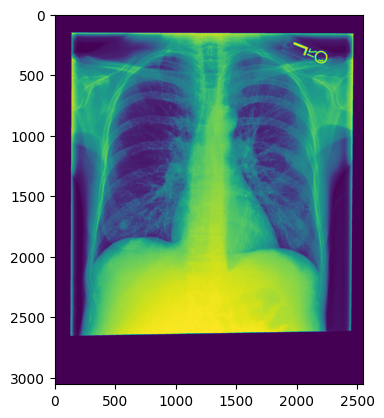

In [83]:
import PIL

def display_image(image_path):
    image = PIL.Image.open(image_path)
    plt.imshow(image)
    plt.show()

# Display the first image in the dataframe
display_image(merged['image_path'].iloc[0])


#### Choosing the desired findings

Lets choose the ones with least NaN's in our sample

In [84]:
non_nan_counts = merged.count()

sorted_counts = non_nan_counts.sort_values(ascending=False)
print(sorted_counts)
start_offset = 4
desired_findings = sorted_counts[start_offset:start_offset+4]

desired_findings = desired_findings.index.tolist()
print("\n\nChosen findings: ")
desired_findings


image_id                      659
subject_id                    659
image_path                    659
study_id                      659
Pleural Effusion              241
No Finding                    233
Edema                         198
Cardiomegaly                  191
Pneumonia                     169
Support Devices               141
Lung Opacity                  137
Atelectasis                   128
Pneumothorax                  104
Consolidation                  83
Enlarged Cardiomediastinum     41
Fracture                       24
Lung Lesion                    22
Pleural Other                   8
dtype: int64


Chosen findings: 


['Pleural Effusion', 'No Finding', 'Edema', 'Cardiomegaly']

In [85]:
#id_columns = set(sorted_counts.index.tolist()[:start_offset])
id_columns = set(['image_path', "study_id"])
print("Id columns (x):", id_columns)

all_labels = set(merged.columns) - id_columns

dropped_labels = all_labels - set(desired_findings)

print("Findings (y): ", desired_findings)

Id columns (x): {'study_id', 'image_path'}
Findings (y):  ['Pleural Effusion', 'No Finding', 'Edema', 'Cardiomegaly']


In [86]:
pacientes = merged.drop(columns=dropped_labels)

# put x at beginning
pacientes = pacientes[pacientes.columns[::-1]]
pacientes

,image_path,Pleural Effusion,No Finding,Edema,Cardiomegaly,study_id
0,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,50414267
1,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,50414267
2,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,53189527
3,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,53189527
4,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,53911762
...,...,...,...,...,...,...
654,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,56187971
655,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,56187971
656,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,0.0,1.0,0.0,NaN,59818531
657,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,NaN,1.0,NaN,NaN,55557761


### Handling absent values

Our strategy will be replacing all of them by 0, as its the most semantically correct way.

In [87]:
def count_nan_percentage(dataframe):
    total_rows = dataframe.shape[0]

    nan_counts = dataframe.isnull().sum()

    nan_percentages = (nan_counts / total_rows) * 100

    return nan_percentages

nan_percentages = count_nan_percentage(pacientes)

print(nan_percentages)


image_path           0.000000
Pleural Effusion    63.429439
No Finding          64.643399
Edema               69.954476
Cardiomegaly        71.016692
study_id             0.000000
dtype: float64


In [88]:
pacientes = pacientes.fillna(0)

pacientes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 658
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_path        659 non-null    object 
 1   Pleural Effusion  659 non-null    float64
 2   No Finding        659 non-null    float64
 3   Edema             659 non-null    float64
 4   Cardiomegaly      659 non-null    float64
 5   study_id          659 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 36.0+ KB


#### Split into train and test and data leakage prevention

In [89]:
from sklearn.model_selection import train_test_split

unique_studies = pacientes['study_id'].unique()

# we will split the studies, not the rows
train_subject_ids, test_subject_ids = train_test_split(unique_studies, test_size=0.2, random_state=42)

# training/ testing DataFrames
train_df = pacientes[pacientes['study_id'].isin(train_subject_ids)]
test_df = pacientes[pacientes['study_id'].isin(test_subject_ids)]

print("Train info: \n")
print(train_df.info())
print("Test info: \n")

print(test_df.info())


Train info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 2 to 658
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_path        534 non-null    object 
 1   Pleural Effusion  534 non-null    float64
 2   No Finding        534 non-null    float64
 3   Edema             534 non-null    float64
 4   Cardiomegaly      534 non-null    float64
 5   study_id          534 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 29.2+ KB
None
Test info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 653
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_path        125 non-null    object 
 1   Pleural Effusion  125 non-null    float64
 2   No Finding        125 non-null    float64
 3   Edema             125 non-null    float64
 4   Cardiomegaly      125 non-null    

<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.


### Checking Data Leakage


In [90]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs

    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    train_ids = set(df1[patient_col])
    test_ids = set(df2[patient_col])

    # intersection of both sets
    common_ids = train_ids.intersection(test_ids)


    print("Number of common IDs: ", len(common_ids))



    ### END CODE HERE ###

    return len(common_ids) != 0

In [91]:
print(f"leakage between train and test: {check_for_leakage(train_df, test_df, 'study_id')}")

Number of common IDs:  0
leakage between train and test: False


In [92]:
# as we already checked for data leakage, time to remove identifiers

train_df = train_df.drop(columns=['study_id'])
test_df = test_df.drop(columns=['study_id'])

If we get `False` for both, then we're ready to start preparing the datasets for training. Remember to always check for data leakage!

<a name='2-2'></a>
### 2.2 Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them.
- For this we will inherit `Dataset` from Pytorch framework.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1.
    - This will facilitate model training by standardizing the input distribution.
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Pytorch documentation, we have implemented the generator for you. There are a few things to note:
1. We normalize the mean and standard deviation of the data
2. We set the image size to be 224px by 224px

In [93]:
class CustomDataset(Dataset):
    def __init__(self, df, x_col, y_cols, transform=None):
        self.df = df
        self.x_col = x_col
        self.y_cols = y_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df[self.x_col].iloc[idx]
        try:
          image = Image.open(img_path).convert("RGB")
          labels = self.df[self.y_cols].iloc[idx].values
          if self.transform:
              image = self.transform(image)
        except Exception as e:
          raise e
        return image, labels

def get_train_generator(df, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=224, target_h=224):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      df (DataFrame): dataframe specifying training data.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        train_generator (DataLoader): iterator over training set
    """
    print("getting train generator...")

    # Define data transformations
    data_transforms = transforms.Compose([
        transforms.Resize((target_h, target_w)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create custom dataset
    train_dataset = CustomDataset(df, x_col, y_cols, transform=data_transforms)

    return DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )

#### Build a separate generator for valid and test sets

Now we need to build a new generator for validation and testing data.

**Why can't we use the same generator as for the training data?**

Look back at the generator we wrote for the training data.
- It normalizes each image **per batch**, meaning that it uses batch statistics.
- We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
- Knowing the average per batch of test data would effectively give our model an advantage.
    - The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics **computed from the training set**.
* We implement this in the function below.
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set.
* However, since this is extremely large, that would be very time consuming.
* In the interest of time, we'll take a random sample of the dataset and calculate the sample mean and sample standard deviation.

In [94]:
def get_test_generator(test_df, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w=224, target_h=224):
    """
    Return generator for validation set and test set using
    normalization statistics from training set.

    Args:
      valid_df (DataFrame): dataframe specifying validation data.
      test_df (DataFrame): dataframe specifying test data.
      train_df (DataFrame): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        valid_generator (DataLoader) and test_generator: iterators over validation set and test set, respectively
    """
    print("getting valid and test generators...")

    # Define data transformations
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((target_h, target_w), antialias=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create custom datasets
    test_dataset = CustomDataset(test_df, x_col, y_cols, transform=data_transforms)

    # Create data loaders
    test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [95]:
x_col = "image_path"
labels = desired_findings

print("X: ", x_col)
print("Y (labels): ", labels)
train_generator = get_train_generator(train_df, x_col, labels)
test_generator= get_test_generator(test_df, x_col, labels)

X:  image_path
Y (labels):  ['Pleural Effusion', 'No Finding', 'Edema', 'Cardiomegaly']
getting train generator...
getting valid and test generators...


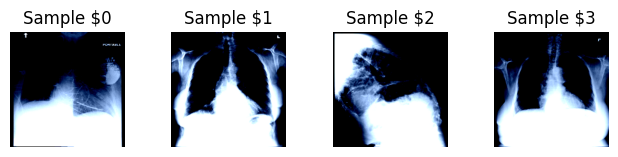

In [96]:
fig = plt.figure()

data_iter = iter(train_generator)
batch_imgs, batch_labels = next(data_iter)

for i in range(0,4):
    img, label = batch_imgs[i].numpy(), batch_labels[i].numpy()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample ${i}')
    ax.axis('off')

    plt.imshow(img.transpose(1, 2, 0))

<a name='3'></a>
## Class imbalance and label encoding


Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

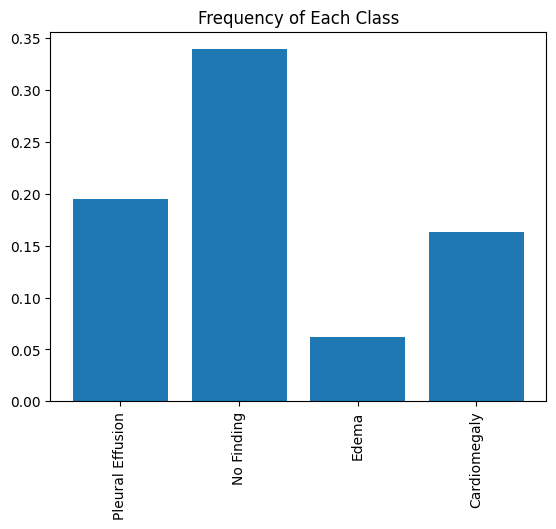

In [97]:
# Calculate the mean frequency of each class
class_frequencies = np.mean(train_df[train_generator.dataset.y_cols].values, axis=0)

# Plot the bar chart
plt.xticks(rotation=90)
plt.bar(x=labels, height=class_frequencies)
plt.title("Frequency of Each Class")
plt.show()


We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.)
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%.
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss.

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive.

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero).

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows:

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is:

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

<a name='Ex-2'></a>
### Exercise 2 - Computing Class Frequencies
Complete the function below to calculate these frequences for each label in our dataset.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Use numpy.sum(a, axis=), and choose the axis (0 or 1) </li>
</ul>
</p>


In [98]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [99]:
freq_pos, freq_neg = compute_class_freqs(train_df[train_generator.dataset.y_cols].values)
freq_pos

array([0.19475655, 0.33895131, 0.06179775, 0.16292135])

In [100]:
freq_neg

array([0.80524345, 0.66104869, 0.93820225, 0.83707865])

Let's visualize these two contribution ratios next to each other for each of the pathologies:

<ipython-input-101-0d5f3b3d3b73>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


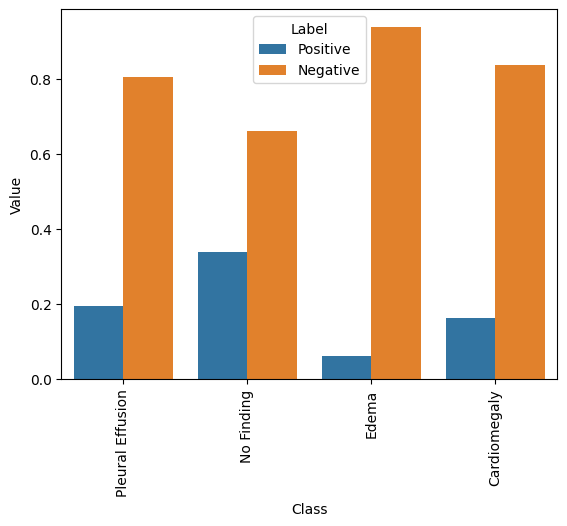

In [101]:
data = pd.DataFrame({"Class": train_generator.dataset.y_cols, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same.

To have this, we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [102]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

<ipython-input-103-978a3fae5356>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


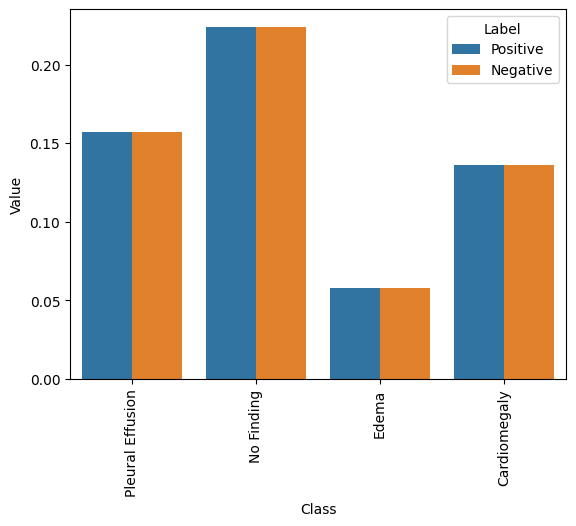

In [103]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function.

After computing the weights, our final weighted loss for each training case will be

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

<a name='Ex-3'></a>
### Exercise 3 - Weighted Loss
Fill out the `weighted_loss` function below to return a loss function that calculates the weighted loss for each batch. Recall that for the multi-class loss, we add up the average loss for each individual class. Note that we also want to add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.

In [104]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        loss = 0.0
        y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
        N = len(pos_weights)

        for i in range(N):
            # for each class, add average weighted loss for that class
            pos_weight = pos_weights[i]
            neg_weight = neg_weights[i]
            awl = - torch.mean(pos_weight * y_true[:, i] * torch.log(y_pred[:, i])
                                + neg_weight * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i])) / N
            #print(f"{i}: AWL {awl}")
            loss += awl

        return loss

        ### END CODE HERE ###
    return weighted_loss

<a name='3-3'></a>
## CNN - DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [105]:
num_epochs = 1

In [106]:
# Create the base pre-trained model
base_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
num_features = base_model.classifier.in_features

base_model.classifier = nn.Sequential(
    nn.Linear(num_features, len(labels)),
    nn.Sigmoid()
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [107]:
X = torch.randn(1, 3, 224, 224)
y = torch.zeros(len(labels))
with torch.no_grad():
    pred = base_model(X).squeeze()

criterion = nn.BCELoss(weight=torch.Tensor(pos_weights))
loss = criterion(y.float(), pred).item()
print(f'loss: {loss}')

loss: 43.62895202636719


### Model training

In [110]:
from tqdm.notebook import tqdm

num_epochs = 1

# Define the loss function
criterion = nn.BCELoss(weight=torch.Tensor(pos_weights))

# Define the optimizer
optimizer = torch.optim.Adam(base_model.parameters())

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)
criterion = criterion.to(device)

# Training loop
for epoch in range(num_epochs):
    base_model.train()
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    t = tqdm(total=len(train_generator), dynamic_ncols=True)
    for i, (x_batch, y_batch) in tqdm(enumerate(train_generator)):
      try:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # Reset the gradients to zero
        optimizer.zero_grad()
        # Generate predictions
        outputs = base_model(x_batch).squeeze()
        # Calculate loss
        loss = criterion(outputs.float(), y_batch.float())
        # Compute gradients
        loss.backward()
        # Upgrade parameters using gradients
        optimizer.step()

        t.set_postfix(loss=loss.item(), refresh=True)
        t.update()
        #if i == 2:
        #    break
      except Exception as e:
        print(e)

        # Following code is just for running this cel in short time.
        # Delete them.
        #if i == 2:
        #    break



Epoch 0/0
----------


  0%|          | 0/67 [00:00<?, ?it/s]

0it [00:00, ?it/s]

### Model evaluation

In [119]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support

def evaluate(model, test_generator):

  # our statistics
  y_true_list = []
  y_pred_list = []

  base_model.eval()

  with torch.no_grad():
      for x_batch, y_batch in tqdm(test_generator):
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)

          outputs = base_model(x_batch)

          predictions = torch.argmax(outputs, dim=1)  # get the class with highest probability

          y_true_list.extend(torch.argmax(y_batch, dim=1).tolist())  # true class index
          y_pred_list.extend(predictions.tolist())




  # After you obtained y_true and y_pred
  precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_list, y_pred_list, average='micro')

  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1_score}")


  return  precision, recall, f1_score

precision, recall, f1_score = evaluate(base_model, test_generator)



  0%|          | 0/16 [00:00<?, ?it/s]

Precision: 0.416
Recall: 0.416
F1-score: 0.416


## Vision transformer

### Setup



In [120]:
!pip install transformers datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install --upgrade  torch torchvision torchaudio

!pip install --upgrade accelerate transformers


In [121]:
import transformers
import accelerate
print(transformers.__version__)
print(accelerate.__version__)


4.30.2
0.20.3


In [122]:
train_df = pacientes[pacientes['study_id'].isin(train_subject_ids)]
test_df = pacientes[pacientes['study_id'].isin(test_subject_ids)]

train_df = train_df.drop(columns=['study_id'])
test_df = test_df.drop(columns=['study_id'])


from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()
def encode_labels(df):
  df = df.copy()
  print(df.info())

  df = df.rename(columns=lambda x: x.replace(' ', ''))

  # Fit and transform each column
  df['PleuralEffusion'] = le.fit_transform(df['PleuralEffusion'])
  df['NoFinding'] = le.fit_transform(df['NoFinding'])
  df['Edema'] = le.fit_transform(df['Edema'])
  df['Cardiomegaly'] = le.fit_transform(df['Cardiomegaly'])


  def load_image(image_path):
      return np.array(PIL.Image.open(image_path))

  # Apply function to each image path and create a new column
  #df['image'] = df['image_path'].apply(load_image)

  return df

train_df = encode_labels(train_df)

test_df = encode_labels(test_df)

train_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 2 to 658
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_path        534 non-null    object 
 1   Pleural Effusion  534 non-null    float64
 2   No Finding        534 non-null    float64
 3   Edema             534 non-null    float64
 4   Cardiomegaly      534 non-null    float64
dtypes: float64(4), object(1)
memory usage: 25.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 653
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_path        125 non-null    object 
 1   Pleural Effusion  125 non-null    float64
 2   No Finding        125 non-null    float64
 3   Edema             125 non-null    float64
 4   Cardiomegaly      125 non-null    float64
dtypes: float64(4), object(1)
memory usage: 5.9+ KB
None


,image_path,PleuralEffusion,NoFinding,Edema,Cardiomegaly
2,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
3,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
4,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
5,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
6,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
...,...,...,...,...,...
654,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
655,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
656,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1
657,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1


In [123]:
labels = ['PleuralEffusion', 'NoFinding', 'Edema', 'Cardiomegaly']

In [124]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel, load_dataset, Image


beans = load_dataset('beans')
beans['train'][0]

  0%|          | 0/3 [00:00<?, ?it/s]

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F5E22287AC0>,
 'labels': 0}

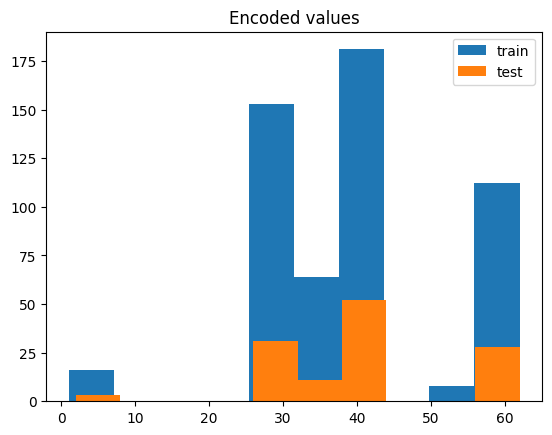

22 unique values:  ['1', '2', '27', '28', '29', '30', '31', '32', '33', '34', '35', '4', '40', '5', '55', '56', '57', '58', '59', '60', '61', '62']
Decode example for 40:  (1, 1, 1, 1)


In [125]:

def decode_classes(encoded_class):
    # Convert base 10 to base 3
    encoded_class = int(encoded_class)
    PleuralEffusion = encoded_class // 3**3
    encoded_class %= 3**3
    NoFinding = encoded_class // 3**2
    encoded_class %= 3**2
    Edema = encoded_class // 3**1
    Cardiomegaly = encoded_class % 3
    return PleuralEffusion, NoFinding, Edema, Cardiomegaly

def encode_classes(row):
    # Convert base 3 to base 10
    encoded = row['PleuralEffusion'] * 3**3 + row['NoFinding'] * 3**2 + row['Edema'] * 3**1 + row['Cardiomegaly'] * 3**0
    return str(encoded)

train_df['labels'] = train_df.apply(encode_classes, axis=1)
test_df['labels'] = test_df.apply(encode_classes, axis=1)

values =train_df['labels']
values2 = test_df['labels']

plt.hist([ int(x) for x in train_df['labels']], label="train")
plt.hist([int(x) for x in test_df['labels']], label="test")

plt.title("Encoded values")
plt.legend()
plt.show()

unique_values = np.unique([*values, *values2]).tolist()
label_count = len(unique_values)

print(label_count, "unique values: ", unique_values)

print("Decode example for 40: ", decode_classes(40))

In [126]:
#train_ds = Dataset.from_pandas(train_df.reset_index(drop=True), split="train")
#test_ds = Dataset.from_pandas(test_df.reset_index(drop=True), split="test")
new_train = train_df.copy()
new_test = test_df.copy()

new_train['labels'] = new_train.apply(encode_classes, axis=1)

new_test['labels'] = new_test.apply(encode_classes, axis=1)

train_dataset = Dataset.from_pandas(new_train.reset_index(drop=True).drop(columns=labels), features=Features({
    'image_path': Value('string'),
    'labels': ClassLabel(num_classes=label_count,names=unique_values)
}))

test_dataset = Dataset.from_pandas(new_test.reset_index(drop=True).drop(columns=labels), features=Features({
    'image_path': Value('string'),
    'labels': ClassLabel(num_classes=label_count,names=unique_values)
}))
# Create DatasetDict
ds = DatasetDict({'train': train_dataset, 'test': test_dataset})
ds


DatasetDict({
    train: Dataset({
        features: ['image_path', 'labels'],
        num_rows: 534
    })
    test: Dataset({
        features: ['image_path', 'labels'],
        num_rows: 125
    })
})

In [127]:
from transformers import ViTFeatureExtractor
from torchvision.transforms.functional import to_tensor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)


# is the largest observed value among the data
total_labels = max(max(values),max(values2))

print("Max label: ", total_labels)

def transform_dataset(example_batch):
    inputs = feature_extractor(
        [to_tensor(PIL.Image.open(x).convert('RGB')) for x in example_batch['image_path']], return_tensors='pt'
    )
    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    """ i'm already doing a encoding
    inputs['PleuralEffusion'] = example_batch['PleuralEffusion']
    inputs['NoFinding'] = example_batch['NoFinding']
    inputs['Edema'] = example_batch['Edema']
    inputs['Cardiomegaly'] =  example_batch['Cardiomegaly']
    """
    return inputs


prepared_ds = ds.with_transform(transform_dataset)
display(train_df.head(2))
prepared_ds['train'][0:2]

Max label:  62


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


,image_path,PleuralEffusion,NoFinding,Edema,Cardiomegaly,labels
2,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1,40
3,/content/drive/MyDrive/tp4_ai_saude/mimic-cxr-...,1,1,1,1,40


{'pixel_values': tensor([[[[-0.9937, -0.9934, -0.9934,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9934, -0.9931, -0.9931,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9934, -0.9931, -0.9932,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9932, -0.9928, -0.9928,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9932, -0.9928, -0.9928,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9942, -0.9938, -0.9938,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.9937, -0.9934, -0.9934,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9934, -0.9931, -0.9931,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9934, -0.9931, -0.9932,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9932, -0.9928, -0.9928,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9932, -0.9928, -0.9928,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9942, -0.9938, -0.9938,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.9937, -0.9934, -0.9934,  ..., -1.0000, -1.0000, -1.0000],
          [-0

In [128]:
def collate_fn(batch):

    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

batch = prepared_ds['train'][0:2]

#display(prepared_ds['train'][0])

#display(prepared_ds['train'].features)

#batch = prepared_ds['train'][0:2]

#collate_fn(prepared_ds['test'])

### Model training

In [133]:
from datasets import load_metric

#metric = load_metric("accuracy")
#def compute_metrics(p):
#    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # get the index of the max log-probability


    recall = recall_score(labels, predictions, average='micro')
    precision = precision_score(labels, predictions, average='micro')
    f1 = f1_score(labels, predictions, average='micro')
    return {
        'recall': recall,
        'precision': precision,
        'f1': f1,
    }



In [134]:
from transformers import ViTForImageClassification, ViTModel
from transformers import TrainingArguments

model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
print(type(model))

labels = prepared_ds['train'].features['labels'].names

#print(labels)

model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=2,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

<class 'transformers.models.vit.modeling_vit.ViTModel'>


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-p

Step,Training Loss,Validation Loss,Recall,Precision,F1
100,2.434000,2.079484,0.416000,0.416000,0.416000
200,2.622700,2.017148,0.416000,0.416000,0.416000


***** train metrics *****
  epoch                    =        1.0
  total_flos               = 38545709GF
  train_loss               =     2.2301
  train_runtime            = 0:11:45.64
  train_samples_per_second =      0.757
  train_steps_per_second   =      0.378


### Error evaluation

In [135]:
metrics_vit = trainer.evaluate()
print(metrics_vit)


{'eval_loss': 2.017148494720459, 'eval_recall': 0.416, 'eval_precision': 0.416, 'eval_f1': 0.416, 'eval_runtime': 124.5912, 'eval_samples_per_second': 1.003, 'eval_steps_per_second': 0.128, 'epoch': 1.0}
